In this project we analyze and study a dataset that contains the following:
    1. Age – Patient’s age in years.
    2. Sex – Gender of the patient (male/female).
    3. Chest Pain Type – Four categories indicating the type of chest pain experienced (4 values).
    4. Resting Blood Pressure – Measured in mm Hg while at rest.
    5. Serum Cholesterol – Cholesterol level in mg/dl.
    6. Fasting Blood Sugar – Indicator if fasting blood sugar > 120 mg/dl (binary).
    7. Resting Electrocardiographic Results – Values: 0, 1, or 2 representing ECG results.
    8. Maximum Heart Rate Achieved – Peak heart rate during exercise.
    9. Exercise-Induced Angina – Presence of angina during exercise (yes/no).
    10. Oldpeak – ST depression induced by exercise relative to rest, a measure of heart stress.
    11. Slope – The slope of the peak exercise ST segment (upsloping, flat, or downsloping).
    12. Number of major vessels (ca) – Count of major vessels (0–3) colored by fluoroscopy.
    13. thal -  A categorical variable indicating thalassemia status: 
            0 = normal
            1 = fixed defect
            2 = reversable defect

The target variable typically indicates the presence or absence of heart disease (binary classification). Our goal is to explore these features, visualize relationships, preprocess the data, and build predictive models to assess heart disease risk.


In [1]:
import pandas as pd # for data manipulation
import numpy as np # for numerical computations
import matplotlib.pyplot as plt
import seaborn as sns # for data visualization
import scipy as sp # for scientific computing
import sklearn as sk # for machine learning
import missingno as msno # for visualizing missing data


df = pd.read_csv("heart.csv")
#print(df.shape) # rows = 1025, columns = 14

if df.isnull().sum().sum() > 0: # Check for missing values
    df = df.dropna() # Remove missing values

# Remove duplicates
df = df.drop_duplicates()


# one hot encoding for categorical columns
df = pd.get_dummies(df, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True) # converts categorical columns into multiple 
#binary (0/1) columns so that machine-learning models can use them correctly.


Here we visualize the relationship between age and cholesterol levels, but instead of using the raw values, we use normalized age and cholesterol. Normalization ensures that both variables are on the same scale, which is important for accurate comparison and visualization. Without scaling, features with larger numeric ranges (like cholesterol) could dominate the analysis and distort patterns.

To achieve this, we apply feature scaling using the MinMaxScaler() method from sklearn.preprocessing. This technique transforms each feature to a fixed range, typically [0, 1], by subtracting the minimum value and dividing by the range (max - min). As a result, all values are proportionally scaled, preserving the relationships between data points while eliminating differences in magnitude.

After scaling, we can plot the normalized age against normalized cholesterol to observe their relationship without bias from differing scales. This step is especially useful for algorithms that rely on distance metrics or gradient descent, and for visualizations where uniform scaling improves interpretability.


Training Shape: (241, 19), Testing Shape: (61, 19)


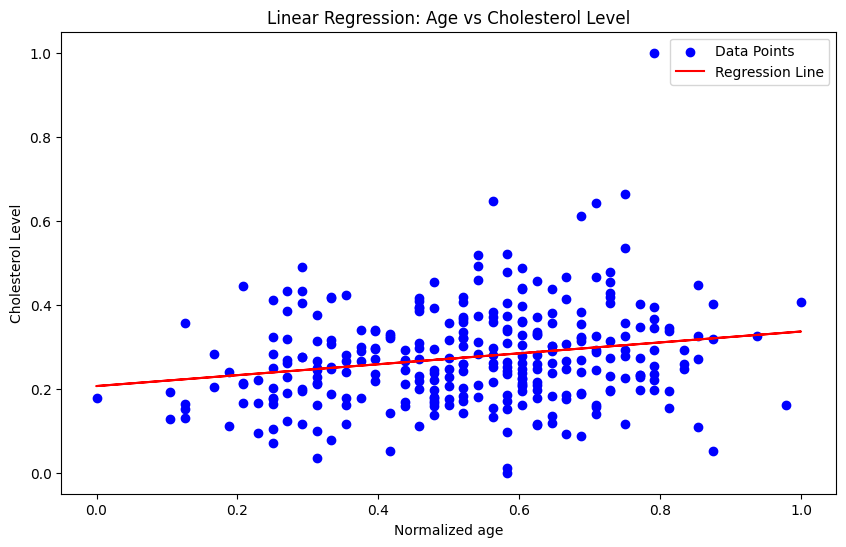

In [2]:
X = df.drop('target', axis=1) # The input variables used to predict something (e.g., age, blood pressure, sex).
Y = df['target'] # The output variable we want to predict (e.g., presence of heart disease). 


# Splitting the dataset into training and testing sets (80% train, 20% test).
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)  



scaler = sk.preprocessing.MinMaxScaler() # Scale features to a range (0, 1)
X_train = scaler.fit_transform(X_train) # Fit scaler on training data and transform it
X_test = scaler.transform(X_test) # Transform test data using the same scaler

print(f"\nTraining Shape: {X_train.shape}, Testing Shape: {X_test.shape}")

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns) # Create a scaled DataFrame for analysis

#use linear regression to find relationship between age and cholesterol
x_reg = df_scaled['age'].values # Independent variable (age)
y_reg = df_scaled['chol'].values # normal chol values = [125, 200], Dependent variable (cholesterol)

regression_results = sp.stats.linregress(x_reg, y_reg) # Perform linear regression on age and cholesterol

slope = regression_results.slope # Slope of the regression line
intercept = regression_results.intercept # Intercept of the regression line
r_value = regression_results.rvalue # Correlation coefficient
p_value = regression_results.pvalue # P-value for the hypothesis test
std_r = regression_results.stderr # Standard error of the estimate

mymodel = []
for age in x_reg:
    predicted_cholesterol = slope * age + intercept
    mymodel.append(predicted_cholesterol)
    pred_funct = np.vectorize(lambda age: slope * age + intercept) # Vectorized function for predictions

plt.figure(figsize=(10, 6))
plt.scatter(x_reg, y_reg, color='blue', label='Data Points') # Scatter plot of age vs cholesterol
plt.plot(x_reg, pred_funct(x_reg), color='red', label='Regression Line') # Regression line
plt.xlabel('Normalized age')
plt.ylabel('Cholesterol Level')
plt.title('Linear Regression: Age vs Cholesterol Level')
plt.legend()
plt.show()


This code learns how age and cholesterol affect blood pressure using linear regression, then predicts the (scaled) blood pressure for all patients and store the predicted resting blood sugar in a new column in the dataframe

In [3]:

# Select features (age, cholesterol) and target (blood pressure)
X_multi = df_scaled[['age', 'chol']]         # Select the feature columns 'age' and 'chol' from the scaled dataframe to use as predictors
y_multi = df_scaled['trestbps']              # Select the target variable 'trestbps' (resting blood pressure)

# Create and train the model
model = sk.linear_model.LinearRegression()   # Initialize a Linear Regression model from scikit-learn
model.fit(X_multi, y_multi)                  # Train (fit) the model using the features X_multi and target y_multi

# View the learned equation
print("Coefficients (Age, Chol):", model.coef_)   # Print the learned slope coefficients for 'age' and 'chol'
print("Intercept:", model.intercept_)             # Print the intercept term (baseline prediction when features are zero)

# Make predictions
predictions = model.predict(X_multi)              # Use the trained model to predict 'trestbps' for the given features
df_scaled['trestbps_pred'] = predictions          # Store the predictions in a new column 'trestbps_pred' in the dataframe


# Compare actual vs predicted
print("\nFirst 5 predictions:")                             # Print a header for the sample comparison
print(df_scaled[['trestbps', 'trestbps_pred']].head())      # Show the first 5 rows comparing actual vs predicted blood pressure


Coefficients (Age, Chol): [0.23619226 0.09756667]
Intercept: 0.20281390709839153

First 5 predictions:
   trestbps  trestbps_pred
0  0.292453       0.335146
1  0.433962       0.338062
2  0.481132       0.415254
3  0.509434       0.377428
4  0.415094       0.402619


Polynomial regression: Age VS MAximum heart rate

R-squared value: 0.1598338213408076


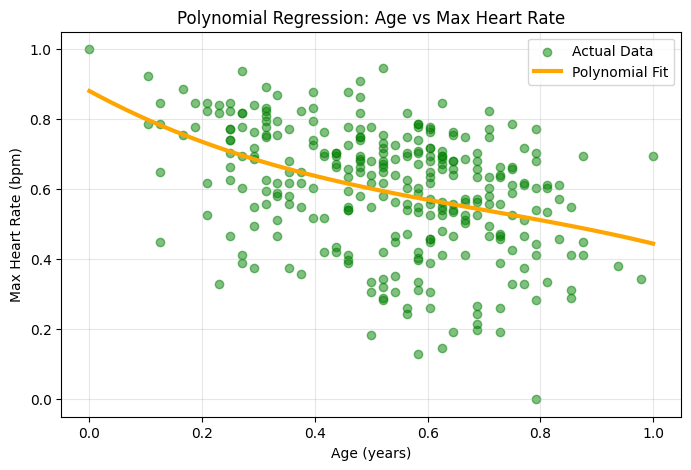

In [4]:
# Extract age and maximum heart rate data from the dataframe
x_poly = df_scaled['age'].values  # Ages of all patients
y_poly = df_scaled['thalach'].values  # Maximum heart rates achieved

# Create a polynomial regression model (3rd degree curve)
# This finds the best-fitting curved line through our data points
# A 3rd degree polynomial can capture more complex patterns than a straight line
mymodel_poly = np.poly1d(np.polyfit(x_poly, y_poly, 3))

# Create 100 evenly-spaced points between min and max age
# This helps us draw a smooth curve on our graph
myline = np.linspace(min(x_poly), max(x_poly), 100)

# Calculate R-squared: measures how well our curve fits the data
# Values closer to 1.0 mean a better fit
print(f"R-squared value: {sk.metrics.r2_score(y_poly, mymodel_poly(x_poly))}")

# Create the visualization
plt.figure(figsize=(8, 5))

# Plot actual data points as green dots
plt.scatter(x_poly, y_poly, color='green', alpha=0.5, label='Actual Data')

# Plot our curved prediction line in orange
plt.plot(myline, mymodel_poly(myline), color='orange', linewidth=3, label='Polynomial Fit')

# Add labels and title
plt.title("Polynomial Regression: Age vs Max Heart Rate")
plt.xlabel("Age (years)")
plt.ylabel("Max Heart Rate (bpm)")
plt.legend()  # Show the legend
plt.grid(True, alpha=0.3)  # Add a light grid for easier reading
plt.show()